In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.3 MB/s eta 0:00:00


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import seaborn as sns
import random
import timm
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

!pip install torch efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

from transformers import BertModel, BertTokenizer
from transformers import XLNetModel, XLNetTokenizer
from transformers import BertForSequenceClassification, XLNetForSequenceClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=ade331c0e8de94766eaf779414e5c92b79c8788cf0e22c68a9caaa6b131511c2
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(50)

In [ ]:
images_path = "/content/drive/MyDrive/images"
train_csv_path = 'train.xlsx'
test_csv_path = 'test.xlsx'

In [ ]:
pip install openpyxl


In [ ]:

import openpyxl
train_df = pd.read_excel(train_csv_path)
test_df = pd.read_csv(test_csv_path)

In [ ]:
train_df

,filename,tweet,label,image
0,buildingfire_2017-02-05_04-06-10.txt,Here's some video of the smoldering ruins in W...,damaged_infrastructure,buildingfire_2017-02-05_04-06-10.JPG
1,isiscrimes_2015-08-04_00-18-33.txt,27 person were killed yesterday near idlib nor...,human_damage,isiscrimes_2015-08-04_00-18-33.JPG
2,earthquake_2017-11-13_07-23-10.txt,تصویری از خسارات زلزله در سرپل ذهاب\n#earthqua...,damaged_infrastructure,earthquake_2017-11-13_07-23-10.JPG
3,ad_2017-11-25_07-56-53.txt,Link in bio #fashion #style #dt #friends #Inst...,non_damage,ad_2017-11-25_07-56-53.JPG
4,hurricanesandy_2017-10-29_22-36-42.txt,Covering the aftermath of Hurricane #Sandy 5 y...,flood,hurricanesandy_2017-10-29_22-36-42.JPG
...,...,...,...,...
5242,cars_2017-10-30_17-48-22.txt,Tuner Evo SoCal \nOfficial Vendor/Sponsor \n@t...,non_damage,cars_2017-10-30_17-48-22.JPG
5243,buildingfire_2016-12-07_17-48-56.txt,Building fire yesterday in Boulder City #fire ...,fires,buildingfire_2016-12-07_17-48-56.JPG
5244,nature_2017-10-30_17-47-15.txt,Walking in the forest is soooooo relaxing ! \n...,non_damage,nature_2017-10-30_17-47-15.JPG
5245,ad_2017-11-25_11-07-37.txt,"a blue dream,💙 Use the code ""VANESSA35"" to get...",non_damage,ad_2017-11-25_11-07-37.JPG


In [ ]:
rows_with_empty_values = train_df[train_df.isna().any(axis=1)]
print(rows_with_empty_values)

                        filename tweet       label                       image
2445  ad_2017-11-25_09-14-52.txt   NaN  non_damage  ad_2017-11-25_09-14-52.JPG


In [ ]:
test_df

,filename,tweet,label,image
0,ad_2017-11-25_10-36-26.txt,⭐ We are really getting into the christmas spi...,non_damage,ad_2017-11-25_10-36-26.JPG
1,building_2017-10-30_17-26-34.txt,IJOY uv board has the competetive price and ve...,non_damage,building_2017-10-30_17-26-34.JPG
2,floodwater_2017-09-04_04-46-10.txt,Arriving in Kalkundi island destroyed in #bang...,flood,floodwater_2017-09-04_04-46-10.JPG
3,accrafloods_2015-06-06_16-59-56.txt,"Hi my lovelies, check out My first hand exper...",flood,accrafloods_2015-06-06_16-59-56.JPG
4,buildingfire_2016-10-02_03-07-17.txt,The Hamilton fire service during an exercise a...,fires,buildingfire_2016-10-02_03-07-17.JPG
...,...,...,...,...
579,floodwater_2017-08-27_23-49-50.txt,#gameofthrones #naturaldisaster #naturalmote #...,flood,floodwater_2017-08-27_23-49-50.JPG
580,nature_2017-10-30_17-47-50.txt,İyi İnsanlara Çıksın Gittiğimiz Tüm Yollar 🙏🏻❤...,non_damage,nature_2017-10-30_17-47-50.JPG
581,earthquake_2017-11-13_23-23-28.txt,Pray for Iran_kermanshah🙏🙏🙏\n.\nکرمانشاهم شهر ...,damaged_infrastructure,earthquake_2017-11-13_23-23-28.JPG
582,ad_2017-11-25_08-21-38.txt,A little hand painting using @framarint brushe...,non_damage,ad_2017-11-25_08-21-38.JPG


In [ ]:
rows_with_empty_values = test_df[test_df.isna().any(axis=1)]
print(rows_with_empty_values)

Empty DataFrame
Columns: [filename, tweet, label, image]
Index: []


In [ ]:
train_df['tweet'][0]

"Here's some video of the smoldering ruins in White Hall, IL. When I left I smelled like a campfire. 3 massive buildings destroyed by a giant fire. A local woman told me about it all. Just unbelievably sad. So much history and such a historic loss in a really small town. #smalltownusa #whitehall #centralillinois #illinois_shots #architecture #brickstagram #firedamage #buildingruins #exploreillinois #buildingfire"

In [ ]:
print(len(train_df))
print(len(test_df))

5247
584


In [ ]:
class_labels= ['ND','DI','DN','Fires','Flood','HD']

In [ ]:
trdata = {
    'image': [],
    'tweet': [],
    'label': []
}
combinedf = pd.DataFrame(trdata)

tedata = {
    'image': [],
    'tweet': [],
    'label': []
}
testdf = pd.DataFrame(tedata)

label_map = {
    "non_damage": 0,
    "damaged_infrastructure": 1,
    "damaged_nature": 2,
    "fires": 3,
    "flood": 4,
    "human_damage": 5
}

combinedf['label'] = train_df['label'].map(label_map)
testdf['label'] = test_df['label'].map(label_map)

def replace_string(row):
  return row.replace('.JPG', '.jpg')
combinedf['image'] = train_df['image'].apply(replace_string)
testdf['image'] = test_df['image'].apply(replace_string)

combinedf['tweet']= train_df['tweet']
testdf['tweet']= test_df['tweet']
# combinedf['tweet'].fillna('', inplace=True)
# testdf['tweet'].fillna('', inplace=True)

In [ ]:
rows_with_empty_values = combinedf[combinedf.isna().any(axis=1)]
print(rows_with_empty_values)

                           image tweet  label
2445  ad_2017-11-25_09-14-52.jpg   NaN      0


In [ ]:
rows_with_empty_values = testdf[testdf.isna().any(axis=1)]
print(rows_with_empty_values)

Empty DataFrame
Columns: [image, tweet, label]
Index: []


In [ ]:
combinedf = combinedf.dropna().reset_index(drop=True)

In [ ]:
rows_with_empty_values = combinedf[combinedf.isna().any(axis=1)]
print(rows_with_empty_values)

Empty DataFrame
Columns: [image, tweet, label]
Index: []


In [ ]:
#combinedf = shuffle(combinedf, random_state=42)
traindf=combinedf[:4662]
validdf= combinedf[4662:]

In [ ]:
print(len(combinedf))
print(len(traindf))
print(len(validdf))
print(len(testdf))

5246
4662
584
584


In [ ]:
# traindf['image_exist'] = traindf['image'].apply(lambda x: os.path.exists(os.path.join(images_path, x)))

In [ ]:
# traindf = traindf[traindf['image_exist']]
# traindf = traindf.drop(columns=['image_exist'])

In [ ]:
traindf

,image,tweet,label
0,buildingfire_2017-02-05_04-06-10.jpg,Here's some video of the smoldering ruins in W...,1
1,isiscrimes_2015-08-04_00-18-33.jpg,27 person were killed yesterday near idlib nor...,5
2,earthquake_2017-11-13_07-23-10.jpg,تصویری از خسارات زلزله در سرپل ذهاب\n#earthqua...,1
3,ad_2017-11-25_07-56-53.jpg,Link in bio #fashion #style #dt #friends #Inst...,0
4,hurricanesandy_2017-10-29_22-36-42.jpg,Covering the aftermath of Hurricane #Sandy 5 y...,4
...,...,...,...
4657,ad_2017-11-25_09-56-23.jpg,Good Morning everyone! What‘s you plan for tod...,0
4658,hurricaneirma_2017-11-21_19-52-42.jpg,#rebuildthekeys #thisisourhome #orcspirit #oce...,2
4659,yemencrisis_2016-02-13_02-40-54.jpg,طفل من ألف طفل قتلتهم السعودية والإمارات..\nلن...,5
4660,building_2017-10-30_17-03-48.jpg,#many #group #city #building #architecture #la...,0


In [ ]:
validdf

,image,tweet,label
4662,treesfalling_2013-12-22_18-58-11.jpg,Ice Storm 2013 ... My street\n❄❄❄❄❄❄❄❄❄\n#ices...,2
4663,ad_2017-11-25_04-12-10.jpg,1_Loveletter Ver.\n[ Follow to the Film ]\nEpi...,0
4664,ad_2017-11-25_10-45-52.jpg,"My text: “Send me coffee”\n•\n•\nSFMOMA bot, t...",0
4665,naturaldisaster_2017-10-13_07-10-42.jpg,Back home time for some cleaning.. @ surf popo...,2
4666,wreckedcar_2017-02-12_16-59-16.jpg,#wreck #car #wreckedcar #winter #snow #honor8,1
...,...,...,...
5241,cars_2017-10-30_17-48-22.jpg,Tuner Evo SoCal \nOfficial Vendor/Sponsor \n@t...,0
5242,buildingfire_2016-12-07_17-48-56.jpg,Building fire yesterday in Boulder City #fire ...,3
5243,nature_2017-10-30_17-47-15.jpg,Walking in the forest is soooooo relaxing ! \n...,0
5244,ad_2017-11-25_11-07-37.jpg,"a blue dream,💙 Use the code ""VANESSA35"" to get...",0


In [ ]:
validdf.reset_index(drop=True, inplace=True)

In [ ]:
validdf

,image,tweet,label
0,treesfalling_2013-12-22_18-58-11.jpg,Ice Storm 2013 ... My street\n❄❄❄❄❄❄❄❄❄\n#ices...,2
1,ad_2017-11-25_04-12-10.jpg,1_Loveletter Ver.\n[ Follow to the Film ]\nEpi...,0
2,ad_2017-11-25_10-45-52.jpg,"My text: “Send me coffee”\n•\n•\nSFMOMA bot, t...",0
3,naturaldisaster_2017-10-13_07-10-42.jpg,Back home time for some cleaning.. @ surf popo...,2
4,wreckedcar_2017-02-12_16-59-16.jpg,#wreck #car #wreckedcar #winter #snow #honor8,1
...,...,...,...
579,cars_2017-10-30_17-48-22.jpg,Tuner Evo SoCal \nOfficial Vendor/Sponsor \n@t...,0
580,buildingfire_2016-12-07_17-48-56.jpg,Building fire yesterday in Boulder City #fire ...,3
581,nature_2017-10-30_17-47-15.jpg,Walking in the forest is soooooo relaxing ! \n...,0
582,ad_2017-11-25_11-07-37.jpg,"a blue dream,💙 Use the code ""VANESSA35"" to get...",0


In [ ]:
testdf

,image,tweet,label
0,ad_2017-11-25_10-36-26.jpg,⭐ We are really getting into the christmas spi...,0
1,building_2017-10-30_17-26-34.jpg,IJOY uv board has the competetive price and ve...,0
2,floodwater_2017-09-04_04-46-10.jpg,Arriving in Kalkundi island destroyed in #bang...,4
3,accrafloods_2015-06-06_16-59-56.jpg,"Hi my lovelies, check out My first hand exper...",4
4,buildingfire_2016-10-02_03-07-17.jpg,The Hamilton fire service during an exercise a...,3
...,...,...,...
579,floodwater_2017-08-27_23-49-50.jpg,#gameofthrones #naturaldisaster #naturalmote #...,4
580,nature_2017-10-30_17-47-50.jpg,İyi İnsanlara Çıksın Gittiğimiz Tüm Yollar 🙏🏻❤...,0
581,earthquake_2017-11-13_23-23-28.jpg,Pray for Iran_kermanshah🙏🙏🙏\n.\nکرمانشاهم شهر ...,1
582,ad_2017-11-25_08-21-38.jpg,A little hand painting using @framarint brushe...,0


In [ ]:
class_counts = traindf['label'].value_counts()
print(class_counts)

0    2366
1    1114
2     405
4     300
3     274
5     203
Name: label, dtype: int64


In [ ]:
class_counts = validdf['label'].value_counts()
print(class_counts)

0    299
1    132
2     54
4     48
3     35
5     16
Name: label, dtype: int64


In [ ]:
class_counts = testdf['label'].value_counts()
print(class_counts)

0    291
1    144
2     55
3     37
4     36
5     21
Name: label, dtype: int64


In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((228, 228)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


transform_test = transforms.Compose([
    transforms.Resize((228, 228)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [ ]:
learning_rate = 3e-3
momentum = 0.9
beta_2 = 0.999
epsilon = None
weight_decay = 0.0
amsgrad = False

In [ ]:
def callbacks_check(model_name):
    num_classes = 6
    accuracy_threshold = 0.99

    class MyCallback:
        def __init__(self):
            self.best_accuracy = 0.0

        def on_epoch_end(self, epoch, accuracy):
            if accuracy > accuracy_threshold:
                print("\nReached {:.2f}% accuracy, so we will stop training".format(accuracy_threshold * 100))
                return True
            return False

    acc_callback = MyCallback()

    return acc_callback

# **Combine**

In [ ]:
class CustomCombinedDataset(Dataset):
    def __init__(self, dataframe, images_path, tokenizer, max_length, transforms=None):
        self.dataframe = dataframe
        self.images_path = images_path
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.transforms = transforms

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_name = os.path.join(self.images_path, self.dataframe.iloc[index]['image'])
        image = Image.open(img_name)
        label = self.dataframe.iloc[index]['label']

        tweet = str(self.dataframe.loc[index, 'tweet'])

        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            return_tensors='pt',
            padding='max_length'
        )

        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()

        if self.transforms is not None:
            image = self.transforms(image)

        return {
            'image': image,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_length= 300

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
combined_train_dataset = CustomCombinedDataset(traindf, images_path, tokenizer, max_length, transforms=transform_train)
combined_valid_dataset = CustomCombinedDataset(validdf, images_path, tokenizer, max_length, transforms=transform_test)
combined_test_dataset = CustomCombinedDataset(testdf, images_path, tokenizer, max_length, transforms=transform_test)

In [ ]:
len(combined_train_dataset)

4662

In [ ]:
criterion = nn.CrossEntropyLoss()
num_classes = 6
batch_size = 12
num_iters= 30000
num_clients = 20
num_selected = 6
num_rounds = 50
epochs = 5


In [ ]:
split_sizes = [len(combined_train_dataset) // num_clients] * num_clients
split_sizes[-1] += len(combined_train_dataset) % num_clients
traindata_split = torch.utils.data.random_split(combined_train_dataset,split_sizes )

In [ ]:
train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]
# combined_valid_loader = DataLoader(combined_valid_dataset, batch_size=batch_size, shuffle=False)
combined_test_loader = DataLoader(combined_test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
len(train_loader)

20

In [ ]:
class MultimodalClassifier(nn.Module):
    def __init__(self):
        super(MultimodalClassifier, self).__init__()

        # Image Model (ResNet-50)
        self.image_model = models.resnet50(pretrained=True)

        num_image_features = self.image_model.fc.in_features
        self.image_model.fc = nn.Sequential(
            nn.Linear(num_image_features, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        # Text Model (BERT)
        self.text_model = BertModel.from_pretrained('bert-base-uncased')
        self.text_linear = nn.Linear(self.text_model.config.hidden_size, 512)

        # Fusion Layer
        self.fusion_linear = nn.Linear(1024, num_classes)

        for param in self.fusion_linear.parameters():
            param.requires_grad = False

    def forward(self, image_input, text_input_ids, text_attention_mask):
        # Process image
        image_features = self.image_model(image_input)

        # Process text
        text_outputs = self.text_model(text_input_ids, attention_mask=text_attention_mask)
        pooled_text_output = text_outputs.pooler_output
        text_features = self.text_linear(pooled_text_output)

        # Concatenate image and text features
        multimodal_features = torch.cat((image_features, text_features), dim=1)

        # Fusion layer
        combined_logits = self.fusion_linear(multimodal_features)

        return combined_logits

In [ ]:
num_classes = 6
dropout_rate= 0.2

In [ ]:
# img_model = ImageModel
# text_model = TextModel

combined_model = MultimodalClassifier()
combined_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s]


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

MultimodalClassifier(
  (image_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seque

In [ ]:
learning_rate = 0.0000001
momentum = 0.9
beta_2 = 0.999
epsilon = None
weight_decay = 0.0
amsgrad = False

In [ ]:
optimizer = optim.Adam(combined_model.parameters(),
                           lr=0.0000001)

criterion = nn.CrossEntropyLoss()
criterion.to(device)

CrossEntropyLoss()

In [ ]:
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

In [ ]:
def client_update(model, optimizer=optimizer, train_loader=train_loader, criterion=criterion, device='cuda', epoch=5):
    """
    This function updates/trains client model on client data for federated learning
    """
    model.train()
    total_loss = 0.0

    for e in range(epoch):
        for batch_idx, batch_data in enumerate(train_loader):
            images = batch_data['image'].to(device)
            input_ids = batch_data['input_ids'].to(device)
            attention_mask = batch_data['attention_mask'].to(device)
            labels = batch_data['label'].to(device)

            optimizer.zero_grad()
            img_output = model(images, input_ids, attention_mask)

            loss = criterion(img_output, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

    avg_loss = total_loss / (epoch * len(train_loader))

    return avg_loss


In [ ]:
def server_aggregate(global_model, client_models):
    """
    This function aggregates client models using the mean method
    """
    global_dict = global_model.state_dict()

    # Take the mean of the weights of models
    for k in global_dict.keys():
        global_dict[k] = torch.stack([client_model.state_dict()[k].float() for client_model in client_models], 0).mean(0)

    # Load the aggregated weights into the global model
    global_model.load_state_dict(global_dict)

    # Update client models with the aggregated global model
    for client_model in client_models:
        client_model.load_state_dict(global_model.state_dict())


In [ ]:
def test(global_model, test_loader):
    """This function tests the global model on test data and returns test loss, accuracy, precision, recall, and F1 score."""
    global_model.eval()
    test_loss = 0
    correct = 0
    all_predictions = []
    all_true_labels = []

    with torch.no_grad():
        for batch in test_loader:
            image = batch['image'].cuda()
            input_ids = batch['input_ids'].cuda()
            attention_mask = batch['attention_mask'].cuda()
            target = batch['label'].cuda()
            output = global_model(image, input_ids, attention_mask)

            test_loss += F.cross_entropy(output, target).item()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            all_predictions.extend(pred.cpu().numpy())
            all_true_labels.extend(target.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)

    precision = precision_score(all_true_labels, all_predictions, average='weighted')
    recall = recall_score(all_true_labels, all_predictions, average='weighted')
    f1 = f1_score(all_true_labels, all_predictions, average='weighted')

    return test_loss, accuracy, precision, recall, f1

In [ ]:
client_models = [MultimodalClassifier() for _ in range(num_selected)]
for model in client_models:
    model.to(device)
    model.load_state_dict(combined_model.state_dict())  # Initial synchronization with the global model

############### Optimizers ################
opt = [optim.SGD(model.parameters(), lr=0.1) for model in client_models]

In [ ]:
from tqdm import tqdm
import time


losses_train = []
losses_test = []
acc_train = []
acc_test = []
precision_test = []
recall_test = []
f1_test = []

# Running FL
for r in range(13):
    # Select random clients
    client_idx = np.random.permutation(num_clients)[:num_selected]

    # Client update
    loss = 0
    for i in tqdm(range(num_selected)):
        loss += client_update(client_models[i], opt[i], train_loader[client_idx[i]], epoch=epochs)

    losses_train.append(loss)

    # Server aggregate
    server_aggregate(combined_model, client_models)

    # Test the combined model on the global test dataset
    test_loss, acc, precision, recall, f1 = test(combined_model, combined_test_loader)
    losses_test.append(test_loss)
    acc_test.append(acc)
    precision_test.append(precision)
    recall_test.append(recall)
    f1_test.append(f1)

    # Print results for the current round
    print('%d-th round' % r)
    print('average train loss %0.3g | test loss %0.3g | test acc: %0.3f | precision: %0.3f | recall: %0.3f | F1: %0.3f' % (loss / num_selected, test_loss, acc, precision, recall, f1))


100%|██████████| 6/6 [17:05<00:00, 170.84s/it]


0-th round
average train loss 1.08 | test loss 0.0679 | test acc: 0.719 | precision: 0.728 | recall: 0.719 | F1: 0.679


100%|██████████| 6/6 [16:49<00:00, 168.28s/it]


1-th round
average train loss 0.672 | test loss 0.0571 | test acc: 0.748 | precision: 0.774 | recall: 0.748 | F1: 0.756


100%|██████████| 6/6 [07:16<00:00, 72.75s/it]


2-th round
average train loss 0.576 | test loss 0.0655 | test acc: 0.711 | precision: 0.783 | recall: 0.711 | F1: 0.721


100%|██████████| 6/6 [07:22<00:00, 73.70s/it]


3-th round
average train loss 0.479 | test loss 0.0646 | test acc: 0.748 | precision: 0.815 | recall: 0.748 | F1: 0.764


100%|██████████| 6/6 [10:58<00:00, 109.71s/it]


4-th round
average train loss 0.455 | test loss 0.0529 | test acc: 0.795 | precision: 0.820 | recall: 0.795 | F1: 0.801


100%|██████████| 6/6 [07:11<00:00, 71.85s/it]


5-th round
average train loss 0.427 | test loss 0.0502 | test acc: 0.801 | precision: 0.818 | recall: 0.801 | F1: 0.805


100%|██████████| 6/6 [07:13<00:00, 72.22s/it]


6-th round
average train loss 0.375 | test loss 0.0476 | test acc: 0.810 | precision: 0.819 | recall: 0.810 | F1: 0.812


100%|██████████| 6/6 [05:22<00:00, 53.75s/it]


7-th round
average train loss 0.352 | test loss 0.0557 | test acc: 0.779 | precision: 0.818 | recall: 0.779 | F1: 0.786


100%|██████████| 6/6 [05:23<00:00, 53.96s/it]


8-th round
average train loss 0.295 | test loss 0.0571 | test acc: 0.767 | precision: 0.810 | recall: 0.767 | F1: 0.779


100%|██████████| 6/6 [07:16<00:00, 72.71s/it]


9-th round
average train loss 0.368 | test loss 0.0486 | test acc: 0.795 | precision: 0.806 | recall: 0.795 | F1: 0.798


100%|██████████| 6/6 [05:27<00:00, 54.55s/it]


10-th round
average train loss 0.265 | test loss 0.0591 | test acc: 0.781 | precision: 0.832 | recall: 0.781 | F1: 0.795


100%|██████████| 6/6 [05:21<00:00, 53.61s/it]


11-th round
average train loss 0.339 | test loss 0.0491 | test acc: 0.810 | precision: 0.843 | recall: 0.810 | F1: 0.820


100%|██████████| 6/6 [05:26<00:00, 54.41s/it]


12-th round
average train loss 0.248 | test loss 0.0567 | test acc: 0.784 | precision: 0.820 | recall: 0.784 | F1: 0.792


Text(0.5, 1.0, 'Test Accuracy')

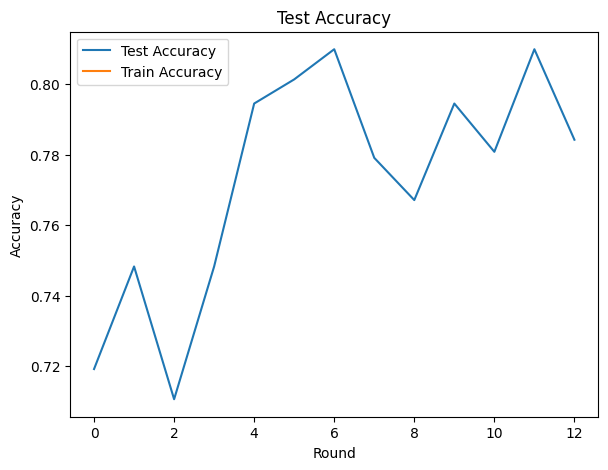

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(acc_test, label='Test Accuracy')

plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Test Accuracy')

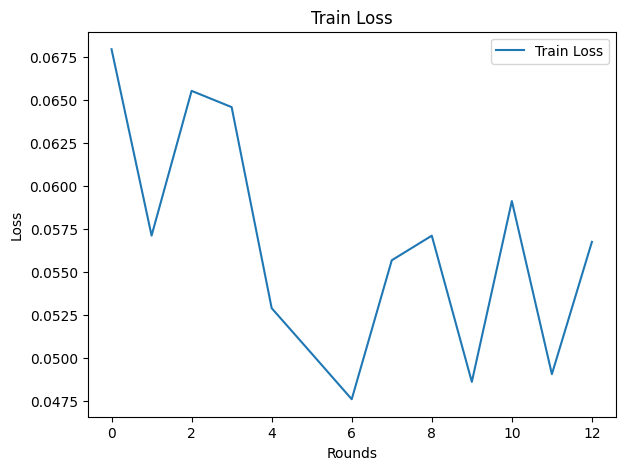

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 2)
plt.plot(losses_test, label='Train Loss')
plt.xlabel('Rounds')
plt.ylabel('Loss')
plt.legend()
plt.title('Train Loss')
plt.show()

In [ ]:
import sys
sys.executable


'/usr/bin/python3'